In [2]:
import os

data_dir = 'C:/study/downloads/jena_climate'
fname = os.path.join(data_dir, 'jena_climate_2009_2016.csv')

f = open(fname)
data = f.read()
f.close()

lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]

print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420551


In [3]:
import numpy as np

float_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]
    float_data[i, :] = values

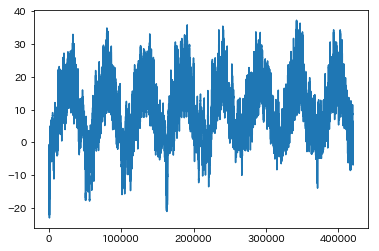

In [5]:
from matplotlib import pyplot as plt

temp = float_data[:, 1]
plt.plot(range(len(temp)), temp)
plt.show()

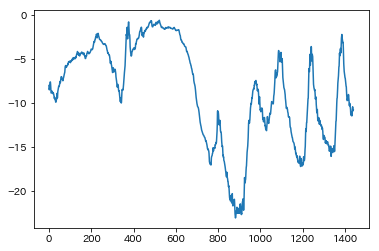

In [6]:
plt.plot(range(1440), temp[:1440])
plt.show()

In [7]:
mean = float_data[:200000].mean(axis=0)
float_data -= mean
std = float_data[:200000].std(axis=0)
float_data /= std

In [8]:
def generator(data, lookback, delay, min_index, max_index,
              shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows),
                           lookback // step,
                           data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples, targets

In [9]:
lookback = 1440
step = 6
delay = 144
batch_size = 128

train_gen = generator(float_data,
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=200000,
                      shuffle=True,
                      step=step, 
                      batch_size=batch_size)
val_gen = generator(float_data,
                    lookback=lookback,
                    delay=delay,
                    min_index=200001,
                    max_index=300000,
                    step=step,
                    batch_size=batch_size)
test_gen = generator(float_data,
                     lookback=lookback,
                     delay=delay,
                     min_index=300001,
                     max_index=None,
                     step=step,
                     batch_size=batch_size)

val_steps = (300000 - 200001 - lookback) // batch_size

test_steps = (len(float_data) - 300001 - lookback) // batch_size

In [11]:
def evaluate_naive_method():
    batch_maes = []
    for step in range(val_steps):
        samples, targets = next(val_gen)
        preds = samples[:, -1, 1]
        mae = np.mean(np.abs(preds - targets))
        batch_maes.append(mae)
    print(np.mean(batch_maes))
    
evaluate_naive_method()

0.289735972991


In [12]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Flatten(input_shape=(lookback // step, float_data.shape[-1])))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Using TensorFlow backend.


Epoch 1/20
500/500 [==============================] - 12s 23ms/step - loss: 1.0680 - val_loss: 0.5879
Epoch 2/20
500/500 [==============================] - 10s 19ms/step - loss: 0.4148 - val_loss: 0.3626
Epoch 3/20
500/500 [==============================] - 10s 19ms/step - loss: 0.2897 - val_loss: 0.3017
Epoch 4/20
500/500 [==============================] - 10s 20ms/step - loss: 0.2656 - val_loss: 0.3328
Epoch 5/20
500/500 [==============================] - 10s 19ms/step - loss: 0.2555 - val_loss: 0.3076
Epoch 6/20
500/500 [==============================] - 10s 20ms/step - loss: 0.2454 - val_loss: 0.3316
Epoch 7/20
500/500 [==============================] - 10s 20ms/step - loss: 0.2373 - val_loss: 0.3169
Epoch 8/20
500/500 [==============================] - 10s 20ms/step - loss: 0.2336 - val_loss: 0.3090
Epoch 9/20
500/500 [==============================] - 10s 20ms/step - loss: 0.2282 - val_loss: 0.3299
Epoch 10/20
500/500 [==============================] - 10s 20ms/step - loss: 0.224

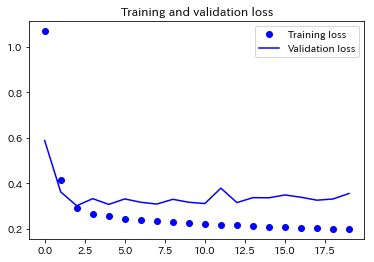

In [13]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [14]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32, input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/20
500/500 [==============================] - 57s 115ms/step - loss: 0.3197 - val_loss: 0.2735
Epoch 2/20
500/500 [==============================] - 57s 114ms/step - loss: 0.2838 - val_loss: 0.2648
Epoch 3/20
500/500 [==============================] - 58s 117ms/step - loss: 0.2763 - val_loss: 0.2655
Epoch 4/20
500/500 [==============================] - 61s 122ms/step - loss: 0.2716 - val_loss: 0.2824
Epoch 5/20
500/500 [==============================] - 67s 134ms/step - loss: 0.2656 - val_loss: 0.2704
Epoch 6/20
500/500 [==============================] - 61s 121ms/step - loss: 0.2611 - val_loss: 0.2669
Epoch 7/20
500/500 [==============================] - 61s 122ms/step - loss: 0.2556 - val_loss: 0.2684
Epoch 8/20
500/500 [==============================] - 67s 134ms/step - loss: 0.2530 - val_loss: 0.2673
Epoch 9/20
500/500 [==============================] - 62s 125ms/step - loss: 0.2482 - val_loss: 0.2714
Epoch 10/20
500/500 [==============================] - 64s 129ms/step - l

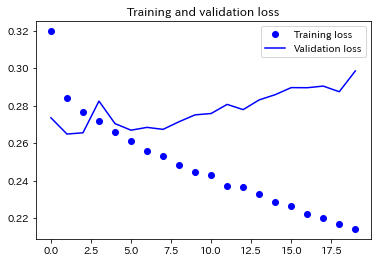

In [15]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

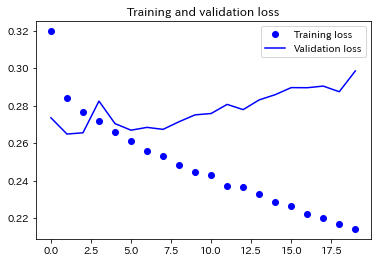

In [16]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [17]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32,
                     dropout=0.1,
                     recurrent_dropout=0.5,
                     return_sequences=True,
                     input_shape=(None, float_data.shape[-1])))
model.add(layers.GRU(64, activation='relu',
                     dropout=0.1, 
                     recurrent_dropout=0.5))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=40,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/40
500/500 [==============================] - 194s 388ms/step - loss: 0.3356 - val_loss: 0.2795
Epoch 2/40
500/500 [==============================] - 185s 370ms/step - loss: 0.3144 - val_loss: 0.2702
Epoch 3/40
500/500 [==============================] - 181s 361ms/step - loss: 0.3065 - val_loss: 0.2694
Epoch 4/40
500/500 [==============================] - 183s 367ms/step - loss: 0.2999 - val_loss: 0.2741
Epoch 5/40
500/500 [==============================] - 183s 366ms/step - loss: 0.2975 - val_loss: 0.2677
Epoch 6/40
500/500 [==============================] - 184s 367ms/step - loss: 0.2958 - val_loss: 0.2704
Epoch 7/40
500/500 [==============================] - 181s 361ms/step - loss: 0.2895 - val_loss: 0.2668
Epoch 8/40
500/500 [==============================] - 182s 363ms/step - loss: 0.2880 - val_loss: 0.2657
Epoch 9/40
500/500 [==============================] - 183s 366ms/step - loss: 0.2846 - val_loss: 0.2670
Epoch 10/40
500/500 [==============================] - 181s 362m

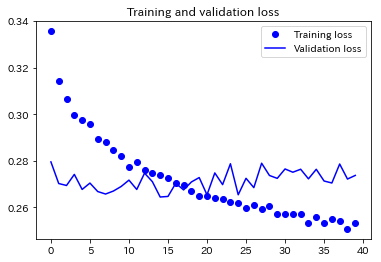

In [18]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [19]:
def reverse_order_generator(data, lookback, delay, min_index, max_index,
                            shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows),
                           lookback // step,
                           data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples[:, ::-1, :], targets
        
train_gen_reverse = reverse_order_generator(
    float_data,
    lookback=lookback,
    delay=delay,
    min_index=0,
    max_index=200000,
    shuffle=True,
    step=step, 
    batch_size=batch_size)
val_gen_reverse = reverse_order_generator(
    float_data,
    lookback=lookback,
    delay=delay,
    min_index=200001,
    max_index=300000,
    step=step,
    batch_size=batch_size)

In [20]:
model = Sequential()
model.add(layers.GRU(32, input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen_reverse,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen_reverse,
                              validation_steps=val_steps)

Epoch 1/20
500/500 [==============================] - 68s 135ms/step - loss: 0.4854 - val_loss: 0.4803
Epoch 2/20
500/500 [==============================] - 66s 133ms/step - loss: 0.4522 - val_loss: 0.4766
Epoch 3/20
500/500 [==============================] - 68s 136ms/step - loss: 0.4009 - val_loss: 0.4569
Epoch 4/20
500/500 [==============================] - 68s 135ms/step - loss: 0.3630 - val_loss: 0.4416
Epoch 5/20
500/500 [==============================] - 64s 128ms/step - loss: 0.3414 - val_loss: 0.4298
Epoch 6/20
500/500 [==============================] - 64s 128ms/step - loss: 0.3270 - val_loss: 0.4302
Epoch 7/20
500/500 [==============================] - 66s 131ms/step - loss: 0.3102 - val_loss: 0.4436
Epoch 8/20
500/500 [==============================] - 66s 133ms/step - loss: 0.2990 - val_loss: 0.4347
Epoch 9/20
500/500 [==============================] - 68s 136ms/step - loss: 0.2899 - val_loss: 0.4466
Epoch 10/20
500/500 [==============================] - 72s 144ms/step - l

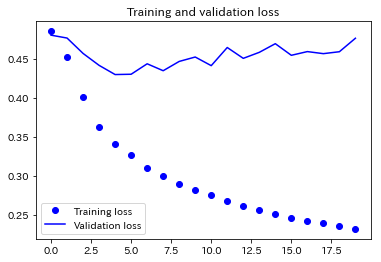

In [21]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [22]:
from keras.datasets import imdb
from keras.preprocessing import sequence
from keras import layers
from keras.models import Sequential

# Number of words to consider as features
max_features = 10000
# Cut texts after this number of words (among top max_features most common words)
maxlen = 500

# Load data
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)

# Reverse sequences
x_train = [x[::-1] for x in x_train]
x_test = [x[::-1] for x in x_test]

# Pad sequences
x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = sequence.pad_sequences(x_test, maxlen=maxlen)

model = Sequential()
model.add(layers.Embedding(max_features, 128))
model.add(layers.LSTM(32))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2)

Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 75s 4ms/step - loss: 0.4936 - acc: 0.7640 - val_loss: 0.4324 - val_acc: 0.8338
Epoch 2/10
20000/20000 [==============================] - 80s 4ms/step - loss: 0.3166 - acc: 0.8780 - val_loss: 0.4312 - val_acc: 0.8214
Epoch 3/10
20000/20000 [==============================] - 78s 4ms/step - loss: 0.2557 - acc: 0.9045 - val_loss: 0.3581 - val_acc: 0.8612
Epoch 4/10
20000/20000 [==============================] - 90s 4ms/step - loss: 0.2147 - acc: 0.9213 - val_loss: 0.7235 - val_acc: 0.7256
Epoch 5/10
20000/20000 [==============================] - 77s 4ms/step - loss: 0.1919 - acc: 0.9306 - val_loss: 0.3952 - val_acc: 0.8436
Epoch 6/10
20000/20000 [==============================] - 82s 4ms/step - loss: 0.1750 - acc: 0.9391 - val_loss: 0.3574 - val_acc: 0.8802
Epoch 7/10
20000/20000 [==============================] - 76s 4ms/step - loss: 0.1556 - acc: 0.9479 - val_loss: 0.6693 - val_acc:

In [23]:
from keras import backend as K
K.clear_session()

In [24]:
model = Sequential()
model.add(layers.Embedding(max_features, 32))
model.add(layers.Bidirectional(layers.LSTM(32)))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(x_train, y_train, epochs=10, batch_size=128, validation_split=0.2)

Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 108s 5ms/step - loss: 0.5577 - acc: 0.7186 - val_loss: 0.4511 - val_acc: 0.8040
Epoch 2/10
20000/20000 [==============================] - 110s 5ms/step - loss: 0.3281 - acc: 0.8735 - val_loss: 0.3266 - val_acc: 0.8640
Epoch 3/10
20000/20000 [==============================] - 114s 6ms/step - loss: 0.2660 - acc: 0.8994 - val_loss: 0.4513 - val_acc: 0.8660
Epoch 4/10
20000/20000 [==============================] - 114s 6ms/step - loss: 0.2387 - acc: 0.9178 - val_loss: 0.3171 - val_acc: 0.8782
Epoch 5/10
20000/20000 [==============================] - 115s 6ms/step - loss: 0.2102 - acc: 0.9262 - val_loss: 0.3408 - val_acc: 0.8888
Epoch 6/10
20000/20000 [==============================] - 113s 6ms/step - loss: 0.1805 - acc: 0.9365 - val_loss: 0.4245 - val_acc: 0.8652
Epoch 7/10
20000/20000 [==============================] - 114s 6ms/step - loss: 0.1696 - acc: 0.9416 - val_loss: 0.4100 - v

In [25]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Bidirectional(
    layers.GRU(32), input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=40,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/40
500/500 [==============================] - 95s 190ms/step - loss: 0.2930 - val_loss: 0.2735
Epoch 2/40
500/500 [==============================] - 105s 210ms/step - loss: 0.2741 - val_loss: 0.2725
Epoch 3/40
500/500 [==============================] - 110s 221ms/step - loss: 0.2665 - val_loss: 0.2695
Epoch 4/40
500/500 [==============================] - 112s 224ms/step - loss: 0.2629 - val_loss: 0.2692
Epoch 5/40
500/500 [==============================] - 106s 212ms/step - loss: 0.2552 - val_loss: 0.2708
Epoch 6/40
500/500 [==============================] - 107s 214ms/step - loss: 0.2482 - val_loss: 0.2746
Epoch 7/40
500/500 [==============================] - 101s 201ms/step - loss: 0.2438 - val_loss: 0.2807
Epoch 8/40
500/500 [==============================] - 105s 209ms/step - loss: 0.2382 - val_loss: 0.2780
Epoch 9/40
500/500 [==============================] - 100s 200ms/step - loss: 0.2316 - val_loss: 0.2819
Epoch 10/40
500/500 [==============================] - 99s 198ms/